In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import rubin_sim.maf as maf
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.site_models import ScheduledDowntimeData, UnscheduledDowntimeData, UnscheduledDowntimeMoreY1Data, CloudData
from rubin_scheduler.site_models import CloudModel
from rubin_scheduler.utils import SURVEY_START_MJD
from downtime import new_downtimes 

In [2]:
# Point to your baseline_v3.6 simulation
opsdb = '../fbs_3.6/baseline_v3.6_10yrs.db'

In [3]:
conn = sqlite3.connect(opsdb)
query = "select observationStartMJD, night, visitExposureTime, visitTime, filter, slewTime, note from observations"
visits = pd.read_sql(query, conn)

In [4]:
start_mjd = SURVEY_START_MJD
start_time = Time(start_mjd, format='mjd', scale='utc')
start_offset = 0 #start_time - Time('2025-01-01') - TimeDelta(0.34, format='jd')
start_mjd

60796.0

In [5]:
almanac = Almanac(start_mjd)

In [6]:
start_idx = np.where(almanac.sunsets['night'] == 0)[0][0]

In [7]:
sunsets = almanac.sunsets[start_idx : start_idx + 3651]['sun_n12_setting']
sunrises = almanac.sunsets[start_idx : start_idx + 3651]['sun_n12_rising']

nights = np.arange(0, 3651, 1)
night_hours = (sunrises - sunsets) * 24
print(len(nights), len(sunsets))

3651 3651


In [8]:
sunsets = almanac.sunsets[start_idx : start_idx + 3651]['sun_n18_setting']
sunrises = almanac.sunsets[start_idx : start_idx + 3651]['sun_n18_rising']
night18_hours = (sunrises - sunsets) * 24

In [9]:
scheduled_downtime = ScheduledDowntimeData(start_time)()
#unscheduled_downtime = UnscheduledDowntimeData(start_time)()
unscheduled_downtime =  UnscheduledDowntimeMoreY1Data(start_time)()
UnscheduledDowntimeMoreY1Data(start_time).night0.mjd

60675.66

In [10]:
unscheduled_downtime[0:1]

array([(<Time object: scale='tai' format='isot' value=2025-01-29T15:50:24.000>, <Time object: scale='tai' format='isot' value=2025-01-30T15:50:24.000>, 'minor event')],
      dtype=[('start', 'O'), ('end', 'O'), ('activity', 'O')])

Text(0, 0.5, 'Days of downtime')

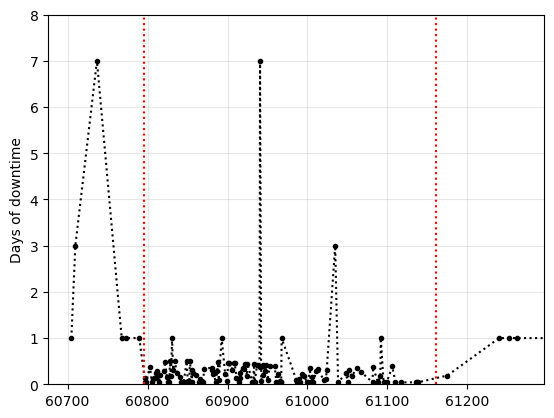

In [11]:
# Looking for a short downtime example, and checking on other things -- just convert unscheduled downtimes in pandas
udt = pd.DataFrame([[t.mjd for t in unscheduled_downtime['start']], 
                    [t.mjd for t in unscheduled_downtime['end']], 
                    unscheduled_downtime['activity']], 
                   index=["start", "end", "activity"]).T
udt['duration'] = udt['end'] - udt['start']
#note that unscheduled downtime starts at the start of the year (as in UnscheduledDowntimeMoreYear1Data.t_start)
plt.plot(udt.start, udt.duration, 'k', marker='.', linestyle=':')
plt.axvline(SURVEY_START_MJD, color='r', linestyle=':')
plt.axvline(SURVEY_START_MJD + 365.25, color='r', linestyle=':')
plt.xlim(60675.66, SURVEY_START_MJD + 500)
plt.ylim(0, 8)
plt.grid(True, alpha=0.3)
plt.ylabel("Days of downtime")
# GOOD - looks like even with 'night0' being the start of the year, the onset of short downtimes is correct, and they last throughout the year.

In [12]:
udt.query("start > @SURVEY_START_MJD and start < @SURVEY_START_MJD + 400")

,start,end,activity,duration
6,60796.204147,60796.340945,Year1 Eng,0.136798
7,60797.076465,60797.118132,Year1 Eng,0.041667
8,60798.149565,60798.191231,Year1 Eng,0.041667
9,60802.987666,60803.369368,Year1 Eng,0.381702
10,60805.265965,60805.307632,Year1 Eng,0.041667
...,...,...,...,...
125,61116.36752,61116.409187,Year1 Eng,0.041667
126,61136.214086,61136.255753,Year1 Eng,0.041667
127,61137.327276,61137.368943,Year1 Eng,0.041667
128,61138.029471,61138.071138,Year1 Eng,0.041667


In [13]:
# What does the scheduler do around this short downtime?
# What time is sunrise on this night? 
udt_i = 8
mjd = udt.iloc[udt_i]['start']
sunsets = almanac.get_sunset_info(mjd)#sunsets[1]['sun_n12_rising']
sunrise = sunsets['sun_n12_rising']
print("sunset", sunsets['sun_n12_setting'], "sunrise", sunsets['sun_n12_rising'])
print("downtime start", udt.iloc[udt_i]['start'], "downtime end", udt.iloc[udt_i]["end"])
start_dt = udt.iloc[udt_i]['start'] - 5 / 60 /24
visits.query('observationStartMJD > @start_dt and observationStartMJD < @sunrise')

sunset 60797.95812464319 sunrise 60798.43080200022
downtime start 60798.14956477869 downtime end 60798.19123144535


,observationStartMJD,night,visitExposureTime,visitTime,filter,slewTime,note
1017,60798.146497,2,29.2,33.6,g,4.804806,
1018,60798.146944,2,29.2,33.6,g,4.941356,
1019,60798.147388,2,29.2,33.6,g,4.836271,
1020,60798.147834,2,29.2,33.6,g,4.895259,
1021,60798.148280,2,29.2,33.6,g,4.933189,
1022,60798.148726,2,29.2,33.6,g,4.912184,
1023,60798.149171,2,29.2,33.6,g,4.919610,


In [14]:
# So visits after the downtime are missing .. is it clouds? -- doesn't look like it
clouds = CloudData(start_time=Time(SURVEY_START_MJD, format='mjd', scale='utc'))
clouds(Time(np.arange(start_dt, sunrise, 10/60/24), scale='utc', format='mjd')).max()

0.0

In [15]:
# Let's look at downtime events:
# Assign downtime hours from scheduled and unscheduled downtime events
mjds = start_mjd + nights
scheddown_hours = np.zeros(len(nights))
for dt in scheduled_downtime:
    idxs = np.where((mjds > dt['start'].mjd) & (mjds < dt['end'].mjd))[0]
    scheddown_hours[idxs] = night_hours[idxs]

unscheddown_hours = np.zeros(len(nights))
for dt in unscheduled_downtime:
    idxs = np.where((mjds > dt['start'].mjd) & (mjds < dt['end'].mjd))[0]
    hours = (dt['end'].mjd - dt['start'].mjd) * 24
    for idx in idxs:
        if hours > night_hours[idx]:
            unscheddown_hours[idx] = night_hours[idx]
        else:
            unscheddown_hours[idx] = hours

# if unscheduled events overlap scheduled ones, use scheduled only
overlaps = np.where((unscheddown_hours > 0) & (scheddown_hours >0))[0]
unscheddown_hours[overlaps] = 0

In [16]:
# Total amount of engineering downtime
scheddown_hours.sum()/10/7, unscheddown_hours.sum()/10/7

(21.888956465625338, 23.89843654227942)

In [17]:
# number of nights with any observations
len(visits.night.unique()),  visits.night.max(), len(visits.night.unique())/visits.night.max()

(2785, 3652, 0.7625958378970427)

<BarContainer object of 399 artists>

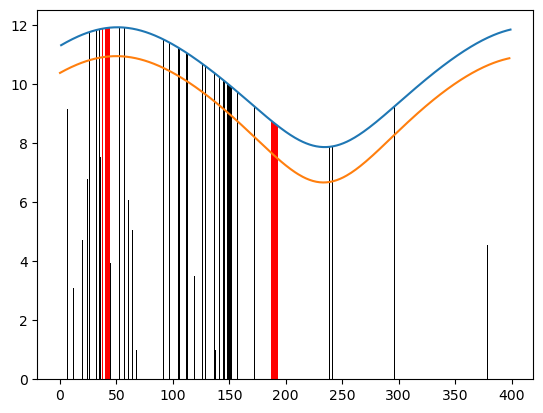

In [18]:
# First - just amount of downtime on any given night, compared to length of night
rr = rr = np.where((nights > 0) & (nights < 400))
plt.plot(nights[rr], night_hours[rr], night18_hours[rr])
plt.bar(nights[rr], scheddown_hours[rr], color='r')
plt.bar(nights[rr], unscheddown_hours[rr], bottom=scheddown_hours[rr], color='k')

In [21]:
# Now let's calculate slewtime for all nights
yy = visits.query('night < @nights.max()')
slewtime = yy.groupby('night').sum('slewTime')['slewTime']/60/60
slewtime_hours = np.zeros(len(nights))
slewtime_hours[slewtime.index] = slewtime.values

In [22]:
# And calculate time in visits (including overhead)
visittime = yy.groupby('night').sum('visitTime')['visitTime']/60/60
visit_hours = np.zeros(len(nights))
visit_hours[visittime.index] = visittime.values

In [23]:
# And calculate open-shutter time
onsky_time = yy.groupby('night').sum('visitExposureTime')['visitExposureTime']/60/60
onsky_hours = np.zeros(len(nights))
onsky_hours[onsky_time.index] = onsky_time.values

# now can calculate overhead for each visit (not including slewtime, just readouts)
visit_overhead = visit_hours - onsky_hours

In [24]:
# calculate actively observing hours
active_hours = slewtime_hours + visit_hours
# so downtime is time not actively observing -- due to scheduled, unscheduled and cloud downtime
down_hours = night_hours - active_hours
# we know downtime hours from scheduled and unscheduled -- assign what is left to clouds
# If the simulation is working properly, this is fine. Unexplained downtime will be assigned to clouds though, if it's not.
cloud_hours = down_hours - scheddown_hours - unscheddown_hours

In [25]:
# what fraction of nights have some cloud down time
len(np.where(cloud_hours > 20/60)[0]) /  3651, 1 - (active_hours / night_hours).mean()

(0.3464804163242947, 0.33871120781711717)

In [26]:
# What fraction of the night, on average, are we observing
(onsky_hours / night_hours).mean(), (onsky_hours / night18_hours).mean()

(0.4740649933382673, 0.5312101047467706)

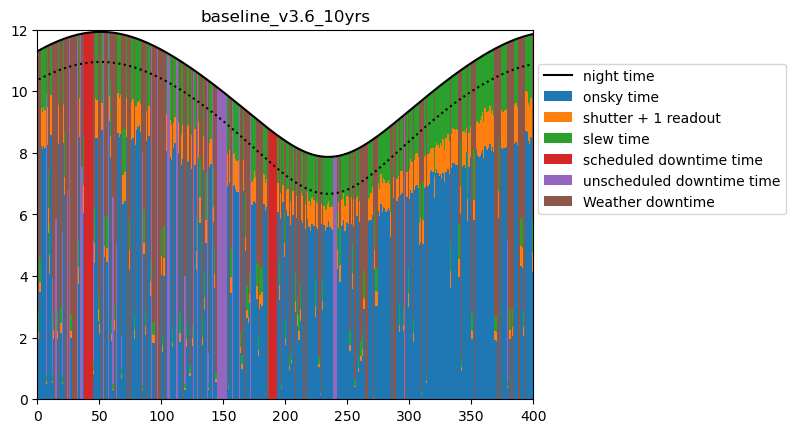

In [27]:
# Make plot of each of these contributions for the first 400 nights
# Remember downtime will be called "Weather" (clouds) if it's not explicitly due to other sources
rr = np.where((nights > 0) & (nights < 400))
plt.plot(nights[rr], night_hours[rr], color='k', label='night time')
plt.plot(nights[rr], night18_hours[rr], color='k', linestyle=':')
base = 0
plt.bar(nights[rr], onsky_hours[rr], width=1, label='onsky time')
base = onsky_hours[rr] * 1
plt.bar(nights[rr], visit_overhead[rr], bottom=base, width=1, label='shutter + 1 readout')
base += visit_overhead[rr]
plt.bar(nights[rr], slewtime_hours[rr], bottom=base, width=1, label="slew time")
base += slewtime_hours[rr]
plt.bar(nights[rr], scheddown_hours[rr], bottom=base, width=1, label='scheduled downtime time')
base += scheddown_hours[rr]
plt.bar(nights[rr], unscheddown_hours[rr], bottom=base, width=1, label='unscheduled downtime time')
base += unscheddown_hours[rr]
plt.bar(nights[rr], cloud_hours[rr], bottom=base, width=1, label="Weather downtime")
plt.legend(loc=(1.01, 0.5))
plt.ylim(0, 12)
plt.xlim(0, 400)
_ = plt.title('baseline_v3.6_10yrs')

Text(0, 0.5, 'Number of nights')

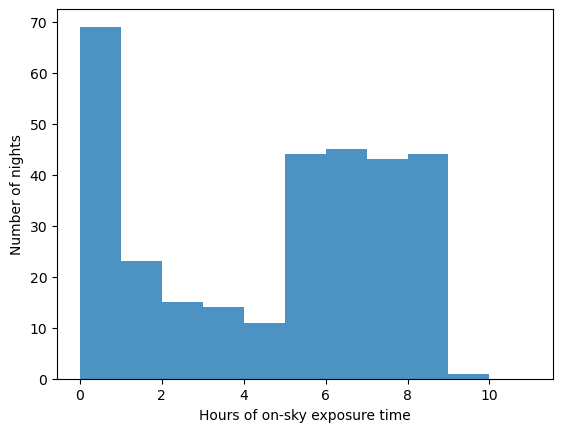

In [28]:
# Histogram of on-sky time
on_sky = onsky_hours[np.where(onsky_hours[rr] > 0)]
#_ = plt.hist(night_hours, bins=np.arange(0, 14, 0.5), histtype='step')
_ = plt.hist(on_sky, bins=np.arange(0, 12, 1), alpha=0.8)
plt.xlabel("Hours of on-sky exposure time")
plt.ylabel("Number of nights")

(0.0, 87.48004655617596)

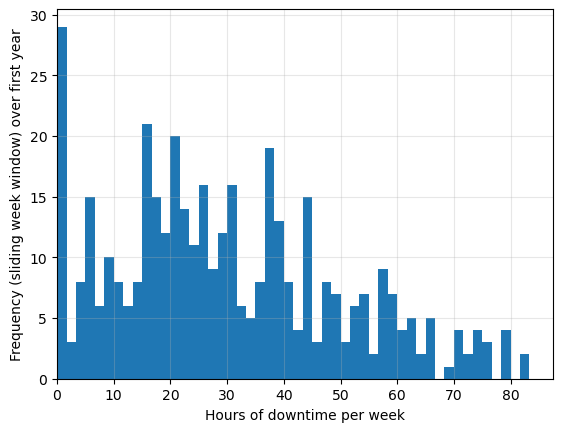

In [29]:
downtime_week = np.convolve(down_hours[rr], np.ones(7))
_ = plt.hist(downtime_week, bins=50)
plt.xlabel("Hours of downtime per week")
plt.ylabel("Frequency (sliding week window) over first year")
plt.grid(True, alpha=0.3)
plt.xlim(0)

(0.0, 87.4811064340174)

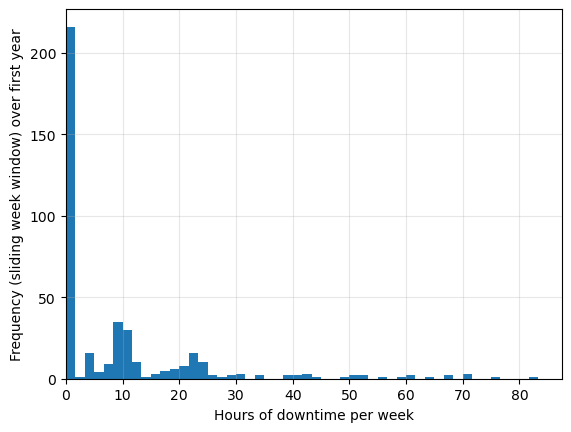

In [30]:
downtime_week = np.convolve((scheddown_hours[rr] + unscheddown_hours[rr]), np.ones(7))
_ = plt.hist(downtime_week, bins=50)
plt.xlabel("Hours of downtime per week")
plt.ylabel("Frequency (sliding week window) over first year")
plt.grid(True, alpha=0.3)
plt.xlim(0)